# YamboCalculation: a single G0W0 run

This is the calcjob class of the plugin that runs a single yambo calculation (p2y+yambo), and does not involve any outputs analysis or further post processing (e.g. automatic determination of quasiparticle band gaps, excitonic eigenvalues).

As in the *02_QE_starting_point* module, we create a builder instance and submit it.

In [11]:
from aiida import orm, load_profile
load_profile()

Profile<uuid='b35700dae723411ea16ebc82d58f16bc' name='mb'>

In [12]:
from aiida.plugins import CalculationFactory

YamboCalculation = CalculationFactory('yambo.yambo')
builder = YamboCalculation.get_builder()

In [ ]:
builder. # + tab completion

## Setting *yambo*, *p2y* codes and resources


In [6]:
builder.code = orm.load_code('yambo-5.1@hydralogin')               #yambo executable
builder.preprocessing_code = orm.load_code('p2y-5.1@hydralogin')   #p2y   executable

In [7]:
builder.metadata.options = {
    'max_wallclock_seconds': 60*60, # in seconds
    'resources': {
            "num_machines": 1, # nodes
            "num_mpiprocs_per_machine": 16, # MPI per nodes
            "num_cores_per_mpiproc": 1, # THREADS
        },
    'prepend_text': u"export OMP_NUM_THREADS="+str(1), # if needed
    #'account':'project_name',
    'queue_name':'s3par',
    #'qos':'',
}

The yambo inputs, used to write the input file (yambo.in -> aiida.in) are provided as a python dictionary, then
stored in the database as an AiiDA Dict. 
Runlevels are included under the 'arguments' key, as a list of strings. Parameters are instead in the 'variables' dictionary, as you can see. The format is the same as *yambopy* (indeed, to write the input file, the code uses the `YamboIn` class, as imported from *yambopy*).

In [8]:
params = {
        'arguments': [
            'dipoles',
            'HF_and_locXC',
            'dipoles',
            'gw0',
            'ppa',],
        'variables': {
            'Chimod': 'hartree',
            'DysSolver': 'n',
            'GTermKind': 'BG',
            'NGsBlkXp': [2, 'Ry'],
            'BndsRnXp': [[1, 50], ''],
            'GbndRnge': [[1, 50], ''],
            'QPkrange': [[[1, 10, 8, 9]], ''],}}

builder.parameters = orm.Dict(dict=params)

You can also provide a settings dictionary, where to specify some instructions (False is default for any of them)

In [11]:
builder.settings = orm.Dict(dict={
    'INITIALISE': False,    # if True, run only p2y and yambo initialization
    'COPY_DBS': False,      # if True, copy the out folder of a previous yambo calculation
    'COPY_SAVE': False,     # if True, copy the SAVE folder of a previous yambo calculation
    'RESTART_YAMBO': False, # if True, soft-link the out folder of a previous yambo calculation
})


#To run  only p2y+yambo init, it is possible to set:
#params_gw = Dict(dict={
#        'arguments': [],
#        'variables': {}})


## Setting the QuantumEspresso parent nscf calculation

Yambo simulations need to have a DFT starting point, i.e. the ground state wavefunctions as obtained in a non self-consistent calculation. This was achieved in the previous module (*02_QE_starting_point*). 
We are gonna use that results and set the `remote_folder` of the nscf as `parent_folder` of our GW simulation.

In [14]:
nscf_pk = 2014 # the pk of the nscf calculation or workchain.


builder.parent_folder = orm.load_node(nscf_pk).outputs.remote_folder

## 3 RUN

In [15]:
from aiida.engine import submit

In [16]:
run = None

In [17]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 38b99615-20c3-4e88-bcff-c7fb98273ead (pk: 2029) (aiida.calculations:yambo.yambo)


# Inspecting the outputs

suppose that your calculation completed successfully:

In [16]:
run.is_finished_ok

True

Then you can access the outputs via the output method of the run instance: 

In [ ]:
run.outputs. #+TAB

For example, we have the array_ndb ArrayData, which essentially contains the information on the run.output.QP_DB (which can also be accessed directly):

In [18]:
run.outputs.array_ndb.get_arraynames()

['E',
 'Z',
 'Eo',
 'Sc',
 'Sx',
 'Vxc',
 'Band',
 'Kpoint',
 'nbands',
 'nkpoints',
 'qp_table',
 'E_minus_Eo',
 'Kpoint_index']

In [19]:
E_dft = run.outputs.array_ndb.get_array('Eo') # Ha units
E_qp = run.outputs.array_ndb.get_array('E')   # Ha units

The `E_dft` and `E_qp` are in Hartree units. We can use the *ase* module `units` to then convert easily to eV, and then plot:

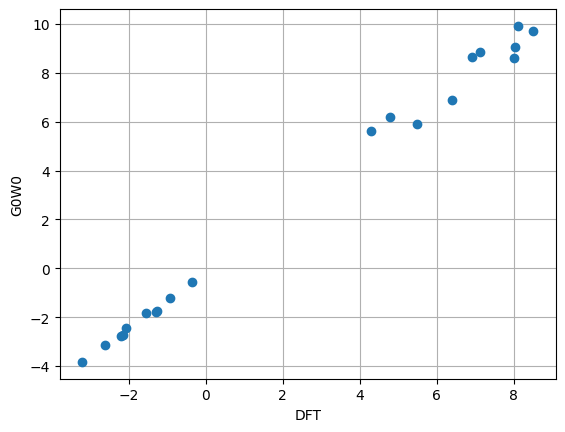

In [22]:
from ase import units
from matplotlib import pyplot as plt

plt.plot(E_dft.real*units.Ha,E_qp.real*units.Ha,'o')
plt.ylabel('G0W0')
plt.xlabel('DFT')
plt.grid()

In [23]:
E_qp

array([-0.06425226+0.0004566j ,  0.21668726-0.00044731j,
       -0.06549172+0.00045731j,  0.3326313 -0.00050405j,
       -0.10030358+0.00048209j,  0.2526744 -0.00045883j,
       -0.10188711+0.00048298j,  0.35731348-0.00043031j,
       -0.0671998 +0.00044998j,  0.31762987-0.00052747j,
       -0.11563124+0.00048145j,  0.32605276-0.00052545j,
       -0.02004499+0.00040752j,  0.20650192-0.00043392j,
       -0.04454358+0.00041815j,  0.22787195-0.00044196j,
       -0.08917301+0.0004802j ,  0.3163973 -0.00048678j,
       -0.1407197 +0.00051105j,  0.36455107-0.00051195j], dtype=complex64)

The `output_parameters` Dict contains information on the simulation:

In [25]:
run.outputs.output_parameters.get_dict()

{'errors': [],
 'timing': [' <---> P1: [01] MPI/OPENMP structure, Files & I/O Directories\n',
  ' <---> P1: [02] CORE Variables Setup\n',
  ' <---> P1: [03] Transferred momenta grid and indexing\n',
  ' <---> P1: [04] Dipoles\n',
  ' <---> P1: [05] Dynamic Dielectric Matrix (PPA)\n',
  ' <04s> P1: [06] Local Exchange-Correlation + Non-Local Fock\n',
  ' <04s> P1: [07] Dyson equation: Newton solver\n',
  ' <05s> P1: [08] Timing Overview\n',
  ' <05s> P1: [09] Game Over & Game summary\n'],
 'has_gpu': False,
 'memstats': [],
 'warnings': [],
 'Fermi(eV)': 5.113534,
 'game_over': True,
 'last_time': 5,
 'para_error': False,
 'time_error': False,
 'ns_db1_path': '/tmp/tmpq_c38i5b',
 'memory_error': False,
 'p2y_completed': True,
 'yambo_version': '5.x',
 'requested_time': 3600,
 'last_time_units': 'seconds',
 'yambo_wrote_dbs': True,
 'corrupted_fragment': False,
 'X_par_allocation_error': False}

As output, also the `ndb.QP` database is stored:

In [28]:
run.outputs.QP_db

<SinglefileData: uuid: 089992d6-97ff-4f0b-8cde-48594901fd80 (pk: 2032)>

This can be used again: for example, we may be interested on BSE simulations on top of these quasiparticle corrections. 
We can do the following (assuming the `builder.parameters` are now the one for a BSE calculation):

```python
    builder.QP_corrections = orm.load_node(2032)   # ---> QP_db node
    params['variables']['KfnQPdb'] =  "E < ./ndb.QP"
    builder.parameters = orm.Dict(dict=params)
```